<a href="https://colab.research.google.com/github/oimartin/Predicting_House_Prices/blob/main/predicting_home_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Prices EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display_html 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# read in training data set for housing prices
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


140000    20
135000    17
145000    14
155000    14
190000    13
          ..
84900      1
424870     1
415298     1
62383      1
34900      1
Name: SalePrice, Length: 663, dtype: int64

163000.0

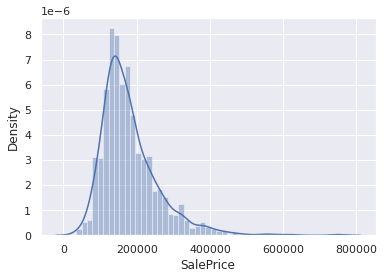

In [2]:
sns.set_theme(color_codes=True)

sns.distplot(train.SalePrice)
display(train.SalePrice.value_counts(dropna=False))
display(train.SalePrice.median())


In [3]:
# Show columns with the missing values
train_na = pd.DataFrame([train.isna()[column].value_counts() 
                         for column in train.columns]).reset_index()
                         
top_na = train_na.rename(columns={'index':'Column',
                             0:'Present',
                             1:'Missing'}).sort_values(by='Missing',
                                                       ascending=False).head(19)
display(top_na)
display(len(top_na))

,Column,Present,Missing
72,PoolQC,7.0,1453.0
74,MiscFeature,54.0,1406.0
6,Alley,91.0,1369.0
73,Fence,281.0,1179.0
57,FireplaceQu,770.0,690.0
3,LotFrontage,1201.0,259.0
58,GarageType,1379.0,81.0
59,GarageYrBlt,1379.0,81.0
60,GarageFinish,1379.0,81.0
63,GarageQual,1379.0,81.0


19

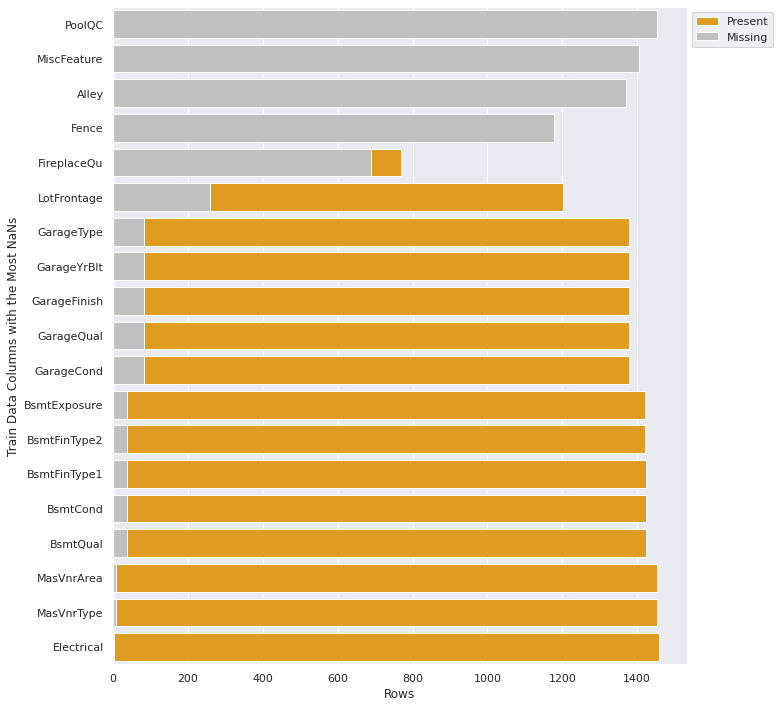

In [4]:
sns.set_theme(color_codes=True)

# Create barplot of 20 columns with the most missing data
plt.figure(figsize=(11,10), frameon=False)
sns.set_color_codes("pastel")
ax = sns.barplot(x="Present", y="Column", data=top_na,
            label="Present", color="orange")

sns.set_color_codes("muted")
ax = sns.barplot(x="Missing", y="Column", data=top_na,
           label='Missing', color='silver')

ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
plt.xlabel('Rows')
plt.ylabel('Train Data Columns with the Most NaNs')
ax.figure.savefig('figures/missing_data.png')
plt.tight_layout()


In [5]:
numerical_missing = list(train[list(top_na['Column'])].describe().columns)
numerical_missing

['LotFrontage', 'GarageYrBlt', 'MasVnrArea']

In [6]:
train_num_fill = pd.DataFrame()
train_num_fill = train[numerical_missing].copy()

for feature in numerical_missing:
  train_num_fill[feature] = train_num_fill[feature].fillna(train_num_fill[feature].median())

train[numerical_missing] = train_num_fill[numerical_missing]


In [7]:
categorical_missing = []
for element in list(top_na['Column']):
  if element not in numerical_missing:
      categorical_missing.append(element)

train[categorical_missing].head()

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtCond,BsmtQual,MasVnrType,Electrical
0,NaN,NaN,NaN,NaN,NaN,Attchd,RFn,TA,TA,No,Unf,GLQ,TA,Gd,BrkFace,SBrkr
1,NaN,NaN,NaN,NaN,TA,Attchd,RFn,TA,TA,Gd,Unf,ALQ,TA,Gd,None,SBrkr
2,NaN,NaN,NaN,NaN,TA,Attchd,RFn,TA,TA,Mn,Unf,GLQ,TA,Gd,BrkFace,SBrkr
3,NaN,NaN,NaN,NaN,Gd,Detchd,Unf,TA,TA,No,Unf,ALQ,Gd,TA,None,SBrkr
4,NaN,NaN,NaN,NaN,TA,Attchd,RFn,TA,TA,Av,Unf,GLQ,TA,Gd,BrkFace,SBrkr


In [8]:
train[categorical_missing].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PoolQC        7 non-null      object
 1   MiscFeature   54 non-null     object
 2   Alley         91 non-null     object
 3   Fence         281 non-null    object
 4   FireplaceQu   770 non-null    object
 5   GarageType    1379 non-null   object
 6   GarageFinish  1379 non-null   object
 7   GarageQual    1379 non-null   object
 8   GarageCond    1379 non-null   object
 9   BsmtExposure  1422 non-null   object
 10  BsmtFinType2  1422 non-null   object
 11  BsmtFinType1  1423 non-null   object
 12  BsmtCond      1423 non-null   object
 13  BsmtQual      1423 non-null   object
 14  MasVnrType    1452 non-null   object
 15  Electrical    1459 non-null   object
dtypes: object(16)
memory usage: 182.6+ KB


In [9]:
# Modify categorical variables where NA means no feature
# Alley and Fence will be modiefied in next step
# Electrical Na will be dropped later
remove = ['QC', 'Qu', 'Type', 'Finish', 'Qual', 'Feature',
          'Cond', 'Exposure', 'FinType1', 'FinType2']

train_cat_fill = pd.DataFrame()
train_cat_fill = train[categorical_missing].copy()

for feature in categorical_missing:
  for suffix in remove:
    if feature.endswith(suffix) is True:
      shrt_feat = feature[0:-len(suffix)]
      train_cat_fill[feature] = train_cat_fill[feature].fillna(f"No_{shrt_feat}")

train_cat_fill.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PoolQC        1460 non-null   object
 1   MiscFeature   1460 non-null   object
 2   Alley         91 non-null     object
 3   Fence         281 non-null    object
 4   FireplaceQu   1460 non-null   object
 5   GarageType    1460 non-null   object
 6   GarageFinish  1460 non-null   object
 7   GarageQual    1460 non-null   object
 8   GarageCond    1460 non-null   object
 9   BsmtExposure  1460 non-null   object
 10  BsmtFinType2  1460 non-null   object
 11  BsmtFinType1  1460 non-null   object
 12  BsmtCond      1460 non-null   object
 13  BsmtQual      1460 non-null   object
 14  MasVnrType    1460 non-null   object
 15  Electrical    1459 non-null   object
dtypes: object(16)
memory usage: 182.6+ KB


In [10]:
train_cat_fill['Alley'] = train_cat_fill['Alley'].fillna('No_Alley')
train_cat_fill['Fence'] = train_cat_fill['Fence'].fillna('No_Fence')
train_cat_fill.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PoolQC        1460 non-null   object
 1   MiscFeature   1460 non-null   object
 2   Alley         1460 non-null   object
 3   Fence         1460 non-null   object
 4   FireplaceQu   1460 non-null   object
 5   GarageType    1460 non-null   object
 6   GarageFinish  1460 non-null   object
 7   GarageQual    1460 non-null   object
 8   GarageCond    1460 non-null   object
 9   BsmtExposure  1460 non-null   object
 10  BsmtFinType2  1460 non-null   object
 11  BsmtFinType1  1460 non-null   object
 12  BsmtCond      1460 non-null   object
 13  BsmtQual      1460 non-null   object
 14  MasVnrType    1460 non-null   object
 15  Electrical    1459 non-null   object
dtypes: object(16)
memory usage: 182.6+ KB


In [11]:
train[categorical_missing] = train_cat_fill[categorical_missing]
train = train.dropna()
# drop electrical NA
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [13]:
# Differentiate numerical features (minus the target) and categorical features
# Inspired by JulienCS's script: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns

In [14]:
cat_encoded = pd.DataFrame()
cat_encoded = train[list(categorical_features)].copy()

le = LabelEncoder()

for feature in categorical_features:
  cat_encoded[f"{feature}_en"] = le.fit_transform(train[feature])

cat_encoded = cat_encoded.iloc[:, 43:].copy()
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,No_Fireplace,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,No_Pool,No_Fence,No_Misc,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,No_Alley,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,No_Pool,No_Fence,No_Misc,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,No_Alley,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,No_Pool,No_Fence,No_Misc,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,No_Alley,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,No_Pool,No_Fence,No_Misc,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,No_Alley,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,No_Pool,No_Fence,No_Misc,0,12,2008,WD,Normal,250000


In [15]:
[display(pd.DataFrame(train[feature].value_counts())) for feature in train[categorical_features]]

,MSZoning
RL,1150
RM,218
FV,65
RH,16
C (all),10


,Street
Pave,1453
Grvl,6


,Alley
No_Alley,1368
Grvl,50
Pave,41


,LotShape
Reg,924
IR1,484
IR2,41
IR3,10


,LandContour
Lvl,1310
Bnk,63
HLS,50
Low,36


,Utilities
AllPub,1458
NoSeWa,1


,LotConfig
Inside,1051
Corner,263
CulDSac,94
FR2,47
FR3,4


,LandSlope
Gtl,1381
Mod,65
Sev,13


,Neighborhood
NAmes,225
CollgCr,150
OldTown,113
Edwards,100
Somerst,86
Gilbert,79
NridgHt,77
Sawyer,74
NWAmes,73
SawyerW,59


,Condition1
Norm,1259
Feedr,81
Artery,48
RRAn,26
PosN,19
RRAe,11
PosA,8
RRNn,5
RRNe,2


,Condition2
Norm,1444
Feedr,6
Artery,2
PosN,2
RRNn,2
RRAn,1
RRAe,1
PosA,1


,BldgType
1Fam,1219
TwnhsE,114
Duplex,52
Twnhs,43
2fmCon,31


,HouseStyle
1Story,726
2Story,445
1.5Fin,154
SLvl,64
SFoyer,37
1.5Unf,14
2.5Unf,11
2.5Fin,8


,RoofStyle
Gable,1140
Hip,286
Flat,13
Gambrel,11
Mansard,7
Shed,2


,RoofMatl
CompShg,1433
Tar&Grv,11
WdShngl,6
WdShake,5
Roll,1
Membran,1
Metal,1
ClyTile,1


,Exterior1st
VinylSd,514
HdBoard,222
MetalSd,220
Wd Sdng,206
Plywood,108
CemntBd,61
BrkFace,50
WdShing,26
Stucco,25
AsbShng,20


,Exterior2nd
VinylSd,503
MetalSd,214
HdBoard,207
Wd Sdng,197
Plywood,142
CmentBd,60
Wd Shng,38
Stucco,26
BrkFace,25
AsbShng,20


,MasVnrType
None,863
BrkFace,445
Stone,128
BrkCmn,15
No_MasVnr,8


,ExterQual
TA,905
Gd,488
Ex,52
Fa,14


,ExterCond
TA,1281
Gd,146
Fa,28
Ex,3
Po,1


,Foundation
PConc,646
CBlock,634
BrkTil,146
Slab,24
Stone,6
Wood,3


,BsmtQual
TA,649
Gd,617
Ex,121
No_Bsmt,37
Fa,35


,BsmtCond
TA,1310
Gd,65
Fa,45
No_Bsmt,37
Po,2


,BsmtExposure
No,952
Av,221
Gd,134
Mn,114
No_Bsmt,38


,BsmtFinType1
Unf,429
GLQ,418
ALQ,220
BLQ,148
Rec,133
LwQ,74
No_Bsmt,37


,BsmtFinType2
Unf,1255
Rec,54
LwQ,46
No_Bsmt,38
BLQ,33
ALQ,19
GLQ,14


,Heating
GasA,1427
GasW,18
Grav,7
Wall,4
OthW,2
Floor,1


,HeatingQC
Ex,741
TA,428
Gd,240
Fa,49
Po,1


,CentralAir
Y,1364
N,95


,Electrical
SBrkr,1334
FuseA,94
FuseF,27
FuseP,3
Mix,1


,KitchenQual
TA,735
Gd,585
Ex,100
Fa,39


,Functional
Typ,1359
Min2,34
Min1,31
Mod,15
Maj1,14
Maj2,5
Sev,1


,FireplaceQu
No_Fireplace,689
Gd,380
TA,313
Fa,33
Ex,24
Po,20


,GarageType
Attchd,870
Detchd,387
BuiltIn,87
No_Garage,81
Basment,19
CarPort,9
2Types,6


,GarageFinish
Unf,605
RFn,422
Fin,351
No_Garage,81


,GarageQual
TA,1310
No_Garage,81
Fa,48
Gd,14
Po,3
Ex,3


,GarageCond
TA,1325
No_Garage,81
Fa,35
Gd,9
Po,7
Ex,2


,PavedDrive
Y,1339
N,90
P,30


,PoolQC
No_Pool,1452
Gd,3
Ex,2
Fa,2


,Fence
No_Fence,1178
MnPrv,157
GdPrv,59
GdWo,54
MnWw,11


,MiscFeature
No_Misc,1405
Shed,49
Gar2,2
Othr,2
TenC,1


,SaleType
WD,1266
New,122
COD,43
ConLD,9
ConLw,5
ConLI,5
CWD,4
Oth,3
Con,2


,SaleCondition
Normal,1197
Partial,125
Abnorml,101
Family,20
Alloca,12
AdjLand,4


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [16]:
[display(pd.DataFrame(cat_encoded[feature].value_counts())) for feature in cat_encoded.columns]

,MSZoning_en
3,1150
4,218
1,65
2,16
0,10


,Street_en
1,1453
0,6


,Alley_en
1,1368
0,50
2,41


,LotShape_en
3,924
0,484
1,41
2,10


,LandContour_en
3,1310
0,63
1,50
2,36


,Utilities_en
0,1458
1,1


,LotConfig_en
4,1051
0,263
1,94
2,47
3,4


,LandSlope_en
0,1381
1,65
2,13


,Neighborhood_en
12,225
5,150
17,113
7,100
21,86
8,79
16,77
19,74
14,73
20,59


,Condition1_en
2,1259
1,81
0,48
6,26
4,19
5,11
3,8
8,5
7,2


,Condition2_en
2,1444
1,6
7,2
4,2
0,2
6,1
5,1
3,1


,BldgType_en
0,1219
4,114
2,52
3,43
1,31


,HouseStyle_en
2,726
5,445
0,154
7,64
6,37
1,14
4,11
3,8


,RoofStyle_en
1,1140
3,286
0,13
2,11
4,7
5,2


,RoofMatl_en
1,1433
5,11
7,6
6,5
4,1
3,1
2,1
0,1


,Exterior1st_en
12,514
6,222
8,220
13,206
9,108
5,61
3,50
14,26
11,25
0,20


,Exterior2nd_en
13,503
8,214
6,207
14,197
10,142
5,60
15,38
12,26
3,25
0,20


,MasVnrType_en
3,863
1,445
4,128
0,15
2,8


,ExterQual_en
3,905
2,488
0,52
1,14


,ExterCond_en
4,1281
2,146
1,28
0,3
3,1


,Foundation_en
2,646
1,634
0,146
3,24
4,6
5,3


,BsmtQual_en
4,649
2,617
0,121
3,37
1,35


,BsmtCond_en
4,1310
1,65
0,45
2,37
3,2


,BsmtExposure_en
3,952
0,221
1,134
2,114
4,38


,BsmtFinType1_en
6,429
2,418
0,220
1,148
5,133
3,74
4,37


,BsmtFinType2_en
6,1255
5,54
3,46
4,38
1,33
0,19
2,14


,Heating_en
1,1427
2,18
3,7
5,4
4,2
0,1


,HeatingQC_en
0,741
4,428
2,240
1,49
3,1


,CentralAir_en
1,1364
0,95


,Electrical_en
4,1334
0,94
1,27
2,3
3,1


,KitchenQual_en
3,735
2,585
0,100
1,39


,Functional_en
6,1359
3,34
2,31
4,15
0,14
1,5
5,1


,FireplaceQu_en
3,689
2,380
5,313
1,33
0,24
4,20


,GarageType_en
1,870
5,387
3,87
6,81
2,19
4,9
0,6


,GarageFinish_en
3,605
2,422
0,351
1,81


,GarageQual_en
5,1310
3,81
1,48
2,14
4,3
0,3


,GarageCond_en
5,1325
3,81
1,35
2,9
4,7
0,2


,PavedDrive_en
2,1339
0,90
1,30


,PoolQC_en
3,1452
2,3
1,2
0,2


,Fence_en
4,1178
2,157
0,59
1,54
3,11


,MiscFeature_en
1,1405
3,49
2,2
0,2
4,1


,SaleType_en
8,1266
6,122
0,43
3,9
5,5
4,5
1,4
7,3
2,2


,SaleCondition_en
4,1197
5,125
0,101
3,20
2,12
1,4


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [17]:
train = train[numerical_features]
train = pd.concat([train, cat_encoded], axis=1)
train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_en,Street_en,...,LotShape_en,LandContour_en,Utilities_en,LotConfig_en,LandSlope_en,Neighborhood_en,Condition1_en,Condition2_en,BldgType_en,HouseStyle_en,RoofStyle_en,RoofMatl_en,Exterior1st_en,Exterior2nd_en,MasVnrType_en,ExterQual_en,ExterCond_en,Foundation_en,BsmtQual_en,BsmtCond_en,BsmtExposure_en,BsmtFinType1_en,BsmtFinType2_en,Heating_en,HeatingQC_en,CentralAir_en,Electrical_en,KitchenQual_en,Functional_en,FireplaceQu_en,GarageType_en,GarageFinish_en,GarageQual_en,GarageCond_en,PavedDrive_en,PoolQC_en,Fence_en,MiscFeature_en,SaleType_en,SaleCondition_en
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,3,1,...,3,3,0,4,0,5,2,2,0,5,1,1,12,13,1,2,4,2,2,4,3,2,6,1,0,1,4,2,6,3,1,2,5,5,2,3,4,1,8,4
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,3,1,...,3,3,0,2,0,24,1,2,0,2,1,1,8,8,3,3,4,1,2,4,1,0,6,1,0,1,4,3,6,5,1,2,5,5,2,3,4,1,8,4
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,3,1,...,0,3,0,4,0,5,2,2,0,5,1,1,12,13,1,2,4,2,2,4,2,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,8,4
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000,3,1,...,0,3,0,0,0,6,2,2,0,5,1,1,13,15,3,3,4,0,4,1,3,0,6,1,2,1,4,2,6,2,5,3,5,5,2,3,4,1,8,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000,3,1,...,0,3,0,2,0,15,2,2,0,5,1,1,12,13,1,2,4,2,2,4,0,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,8,4


In [18]:
# winter: 12, 1, 2 = 1
# Spring: 3, 4, 5 = 2
# Summer: 6, 7, 8 = 3
# Fall: 9, 10, 11 = 4

train['Season'] = train['MoSold'].replace({12: 1, 1: 1, 2: 1, 3: 2,
                                               4: 2, 5: 2, 6: 3, 7: 3,
                                               8: 3, 9: 4, 10: 4, 11: 4})
train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_en,Street_en,...,LandContour_en,Utilities_en,LotConfig_en,LandSlope_en,Neighborhood_en,Condition1_en,Condition2_en,BldgType_en,HouseStyle_en,RoofStyle_en,RoofMatl_en,Exterior1st_en,Exterior2nd_en,MasVnrType_en,ExterQual_en,ExterCond_en,Foundation_en,BsmtQual_en,BsmtCond_en,BsmtExposure_en,BsmtFinType1_en,BsmtFinType2_en,Heating_en,HeatingQC_en,CentralAir_en,Electrical_en,KitchenQual_en,Functional_en,FireplaceQu_en,GarageType_en,GarageFinish_en,GarageQual_en,GarageCond_en,PavedDrive_en,PoolQC_en,Fence_en,MiscFeature_en,SaleType_en,SaleCondition_en,Season
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,3,1,...,3,0,4,0,5,2,2,0,5,1,1,12,13,1,2,4,2,2,4,3,2,6,1,0,1,4,2,6,3,1,2,5,5,2,3,4,1,8,4,1
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,3,1,...,3,0,2,0,24,1,2,0,2,1,1,8,8,3,3,4,1,2,4,1,0,6,1,0,1,4,3,6,5,1,2,5,5,2,3,4,1,8,4,2
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,3,1,...,3,0,4,0,5,2,2,0,5,1,1,12,13,1,2,4,2,2,4,2,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,8,4,4
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000,3,1,...,3,0,0,0,6,2,2,0,5,1,1,13,15,3,3,4,0,4,1,3,0,6,1,2,1,4,2,6,2,5,3,5,5,2,3,4,1,8,0,1
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000,3,1,...,3,0,2,0,15,2,2,0,5,1,1,12,13,1,2,4,2,2,4,0,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,8,4,1


In [25]:
bins = [1870, 1900, 1930, 1960, 1990, 2010]
group_names = [0, 1, 2, 3, 4]
train['YearBuilt_bin'] = pd.cut(train['YearBuilt'], bins, labels=group_names).astype('float')
train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_en,Street_en,...,Utilities_en,LotConfig_en,LandSlope_en,Neighborhood_en,Condition1_en,Condition2_en,BldgType_en,HouseStyle_en,RoofStyle_en,RoofMatl_en,Exterior1st_en,Exterior2nd_en,MasVnrType_en,ExterQual_en,ExterCond_en,Foundation_en,BsmtQual_en,BsmtCond_en,BsmtExposure_en,BsmtFinType1_en,BsmtFinType2_en,Heating_en,HeatingQC_en,CentralAir_en,Electrical_en,KitchenQual_en,Functional_en,FireplaceQu_en,GarageType_en,GarageFinish_en,GarageQual_en,GarageCond_en,PavedDrive_en,PoolQC_en,Fence_en,MiscFeature_en,SaleType_en,SaleCondition_en,Season,YearBuilt_bin
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,3,1,...,0,4,0,5,2,2,0,5,1,1,12,13,1,2,4,2,2,4,3,2,6,1,0,1,4,2,6,3,1,2,5,5,2,3,4,1,8,4,1,4.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,3,1,...,0,2,0,24,1,2,0,2,1,1,8,8,3,3,4,1,2,4,1,0,6,1,0,1,4,3,6,5,1,2,5,5,2,3,4,1,8,4,2,3.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,3,1,...,0,4,0,5,2,2,0,5,1,1,12,13,1,2,4,2,2,4,2,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,8,4,4,4.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000,3,1,...,0,0,0,6,2,2,0,5,1,1,13,15,3,3,4,0,4,1,3,0,6,1,2,1,4,2,6,2,5,3,5,5,2,3,4,1,8,0,1,1.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000,3,1,...,0,2,0,15,2,2,0,5,1,1,12,13,1,2,4,2,2,4,0,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,8,4,1,4.0


Text(0, 0.5, 'Variable Correlation \nto Sale Price')

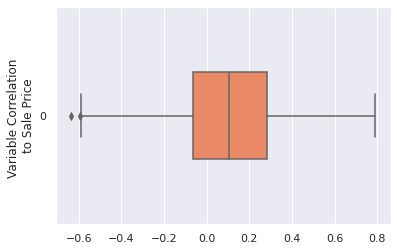

In [27]:
# find correlations between variables and save only 'SalePrice' col
# remove Id and SalePrice columns
SalePrice_corr_train = train.corr()['SalePrice'].drop(labels=['Id', 'SalePrice'])

# Create boxplot of all columns with numerical values correlation to saleprice
sns.set_theme(color_codes=True)

# Take out correlation between SalePrice and itself
sns.boxplot(data=SalePrice_corr_train, orient='h', width=0.4,
           color='coral')
plt.ylabel('Variable Correlation \nto Sale Price')

In [28]:
display(pd.DataFrame(SalePrice_corr_train.describe()))
corr_stats = SalePrice_corr_train.describe()

,SalePrice
count,81.000000
mean,0.118962
std,0.297672
min,-0.636909
25%,-0.066339
50%,0.103658
75%,0.284400
max,0.791069


In [29]:
# Create list of top 25% and bottom 25% of
# columns with numerical value correlations to Sale Price
SalePrice_corr_train_quarters = SalePrice_corr_train[(SalePrice_corr_train >= corr_stats[6]) 
                     | (SalePrice_corr_train <= corr_stats[4])]

sp_corr = pd.DataFrame(SalePrice_corr_train_quarters.sort_values(ascending=False))

sp_corr

,SalePrice
OverallQual,0.791069
GrLivArea,0.708618
GarageCars,0.640473
GarageArea,0.623423
TotalBsmtSF,0.613905
1stFlrSF,0.605968
FullBath,0.560881
TotRmsAbvGrd,0.533779
YearBuilt,0.523273
YearBuilt_bin,0.509874


MSSubClass


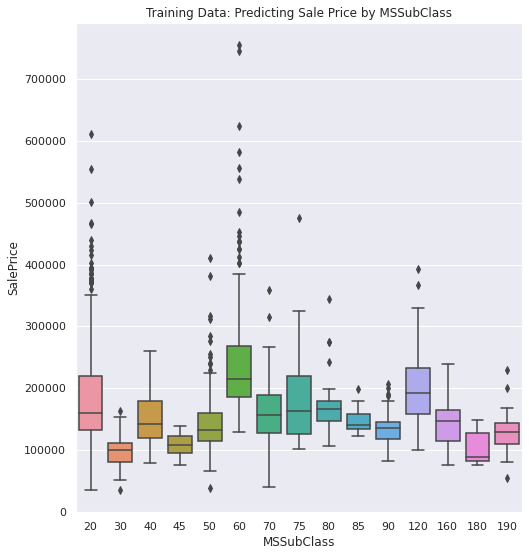

LotFrontage


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

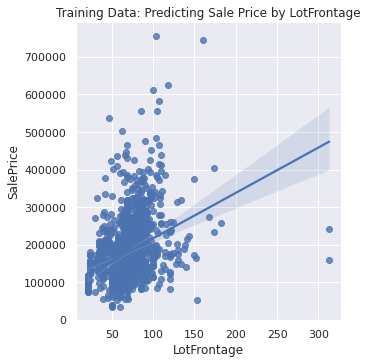

OverallQual


<Figure size 432x288 with 0 Axes>

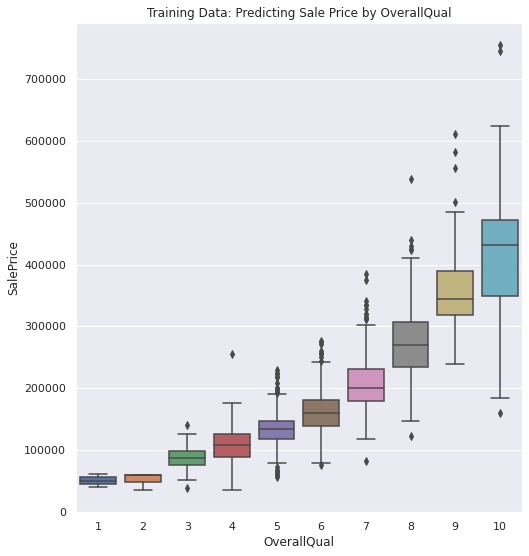

OverallCond


<Figure size 432x288 with 0 Axes>

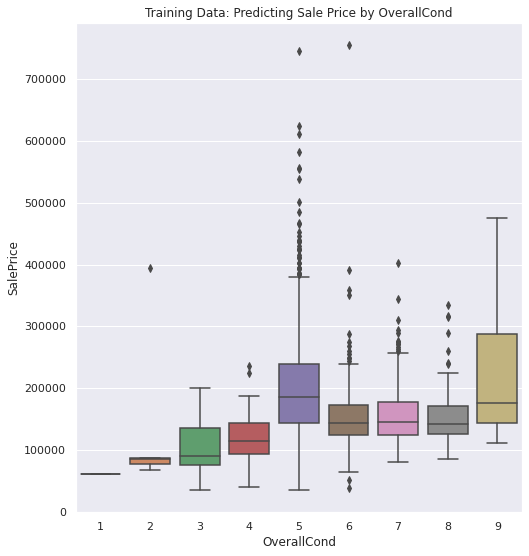

YearBuilt


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

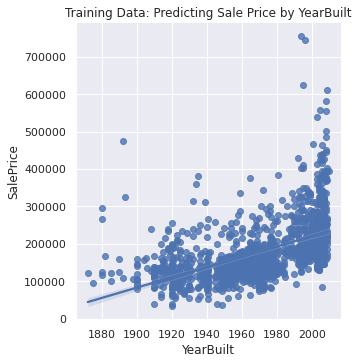

YearRemodAdd


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

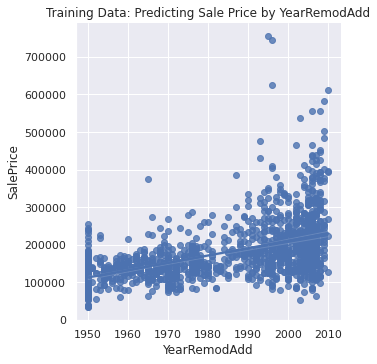

MasVnrArea


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

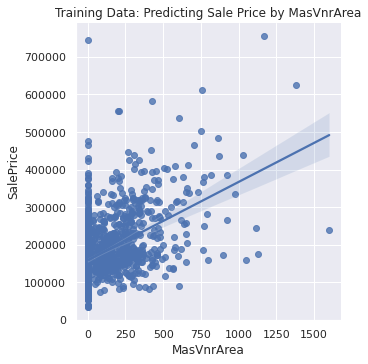

BsmtFinSF1


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

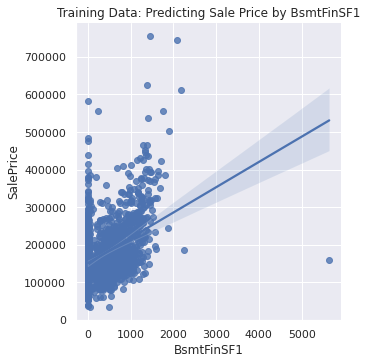

TotalBsmtSF


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

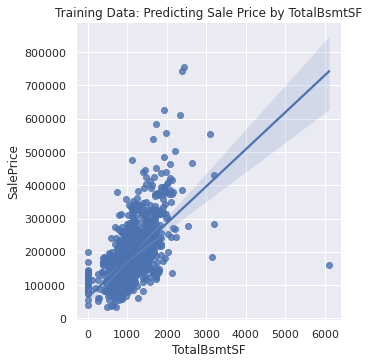

1stFlrSF


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

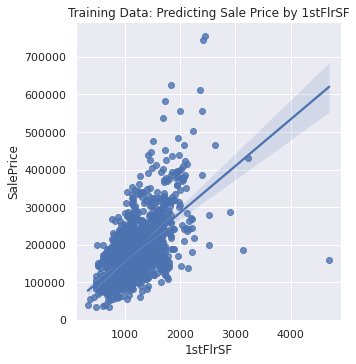

2ndFlrSF


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

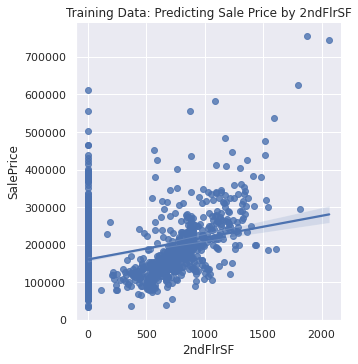

GrLivArea


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

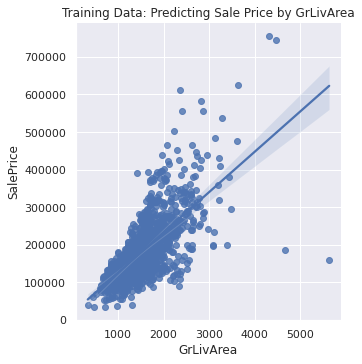

FullBath


<Figure size 432x288 with 0 Axes>

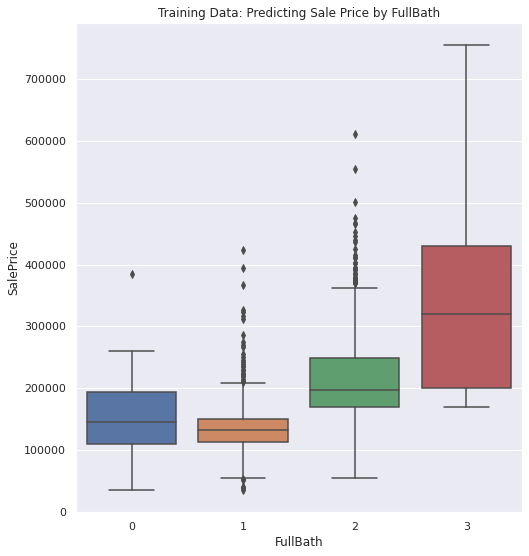

HalfBath


<Figure size 432x288 with 0 Axes>

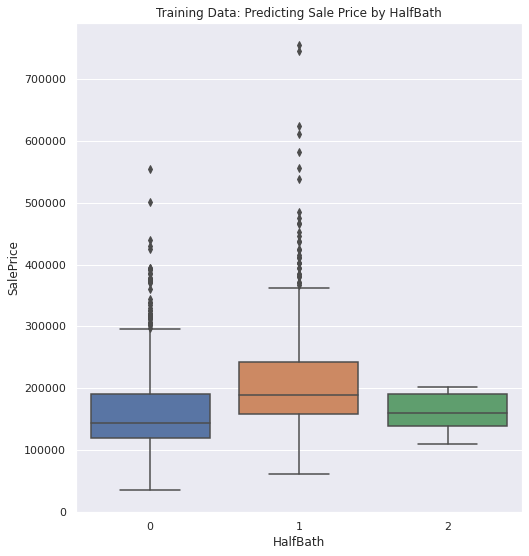

KitchenAbvGr


<Figure size 432x288 with 0 Axes>

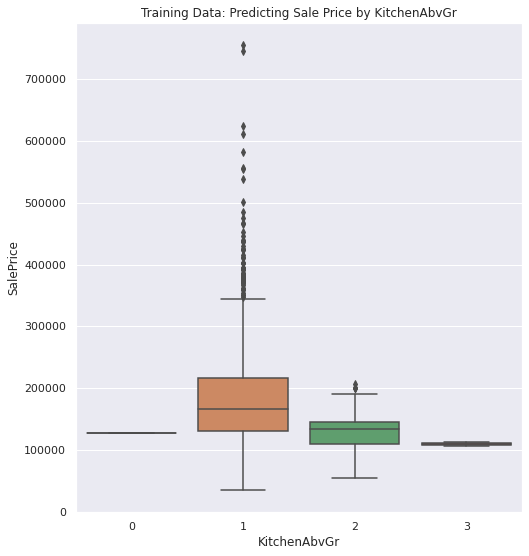

TotRmsAbvGrd


<Figure size 432x288 with 0 Axes>

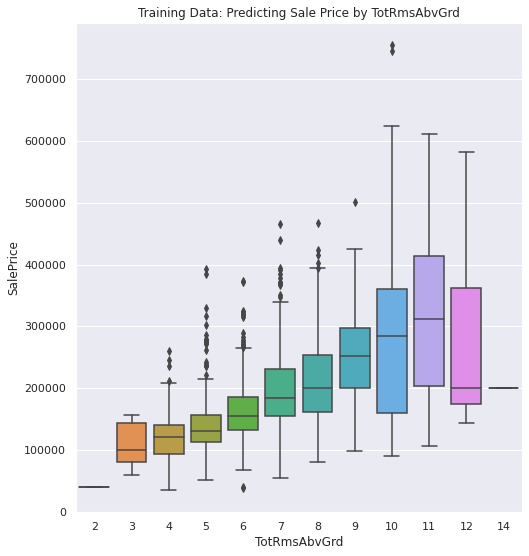

Fireplaces


<Figure size 432x288 with 0 Axes>

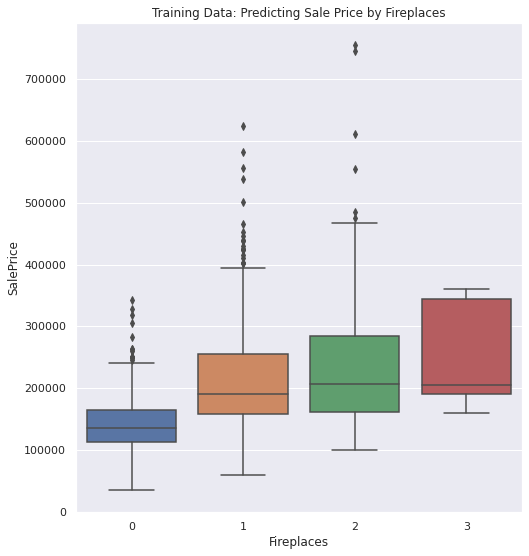

GarageYrBlt


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

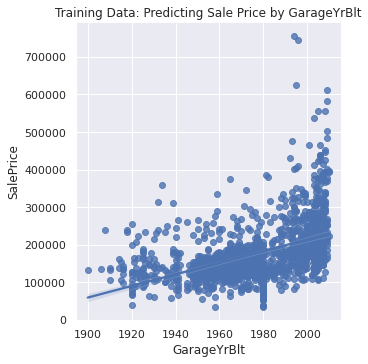

GarageCars


<Figure size 432x288 with 0 Axes>

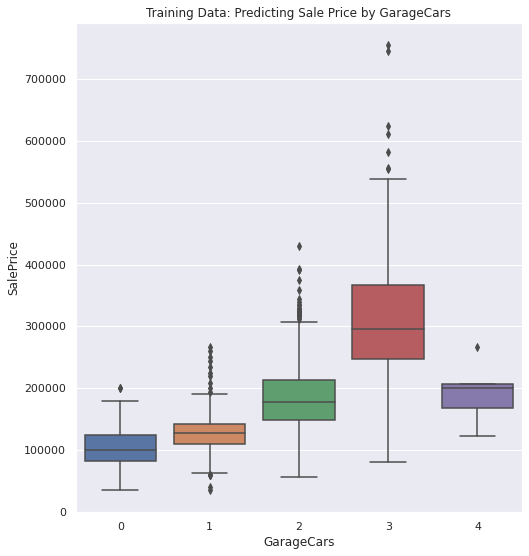

GarageArea


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

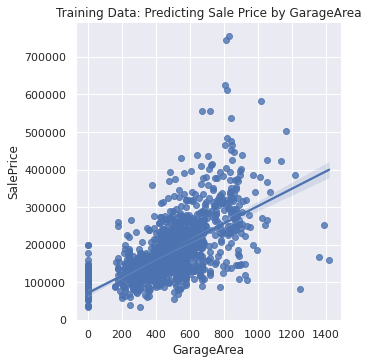

WoodDeckSF


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

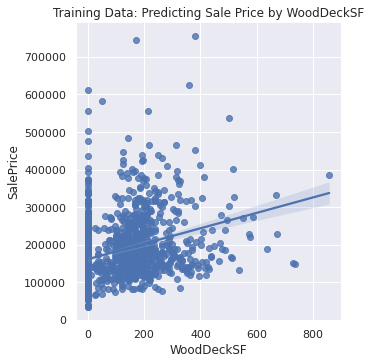

OpenPorchSF


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

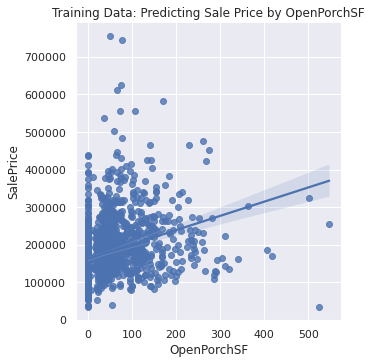

EnclosedPorch


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

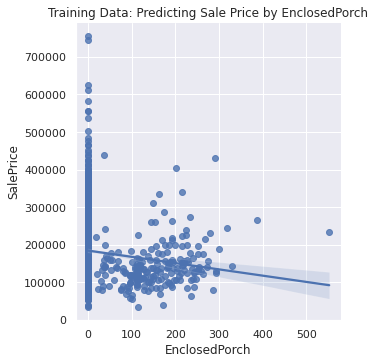

MSZoning_en


<Figure size 432x288 with 0 Axes>

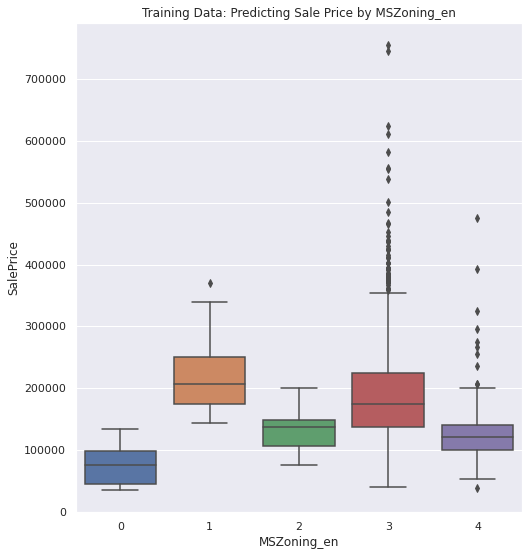

LotShape_en


<Figure size 432x288 with 0 Axes>

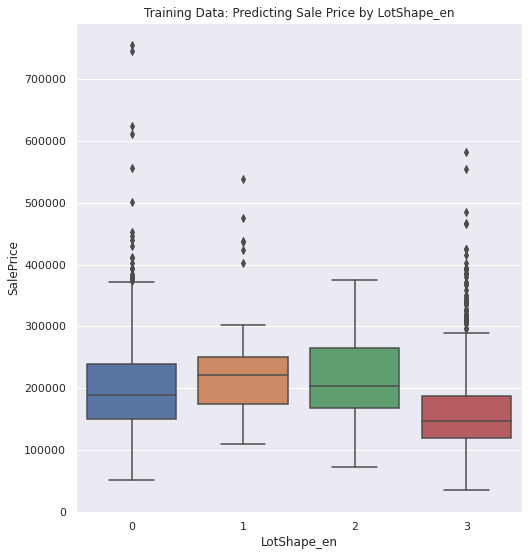

LotConfig_en


<Figure size 432x288 with 0 Axes>

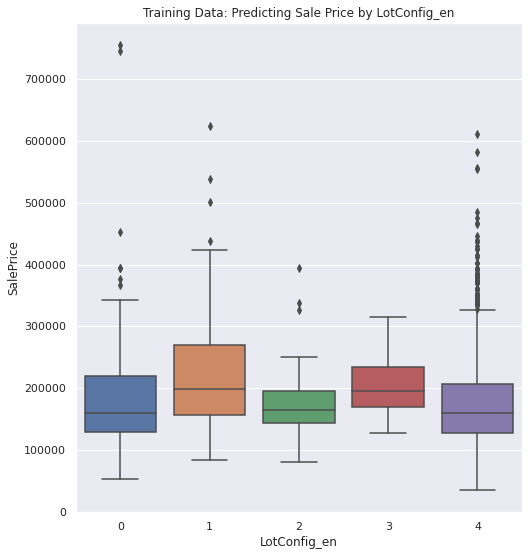

BldgType_en


<Figure size 432x288 with 0 Axes>

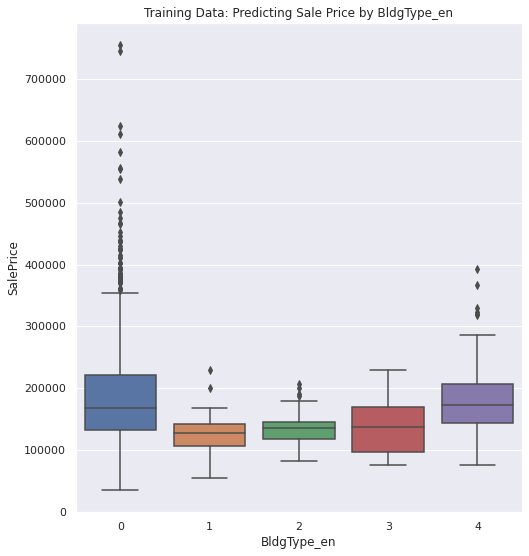

MasVnrType_en


<Figure size 432x288 with 0 Axes>

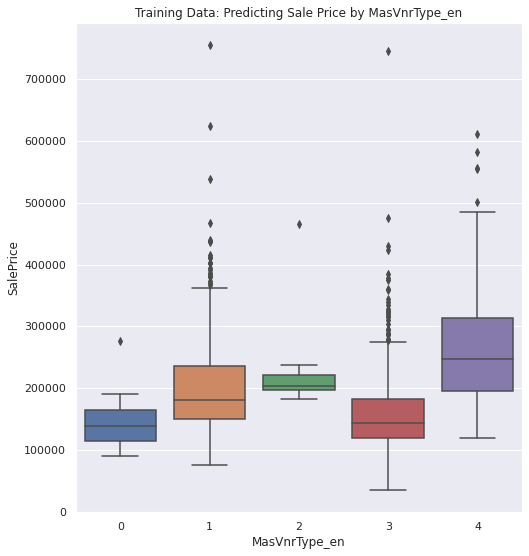

ExterQual_en


<Figure size 432x288 with 0 Axes>

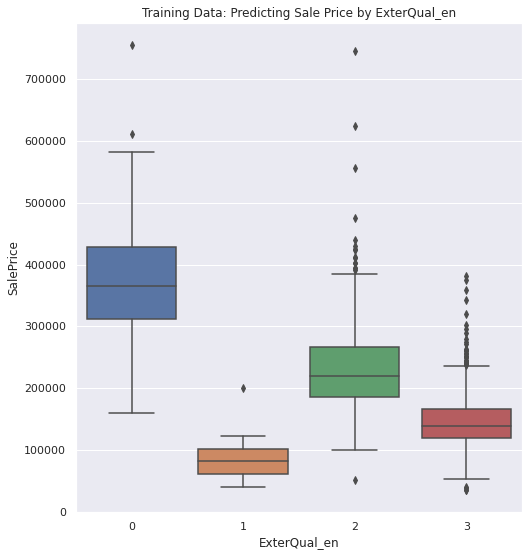

Foundation_en


<Figure size 432x288 with 0 Axes>

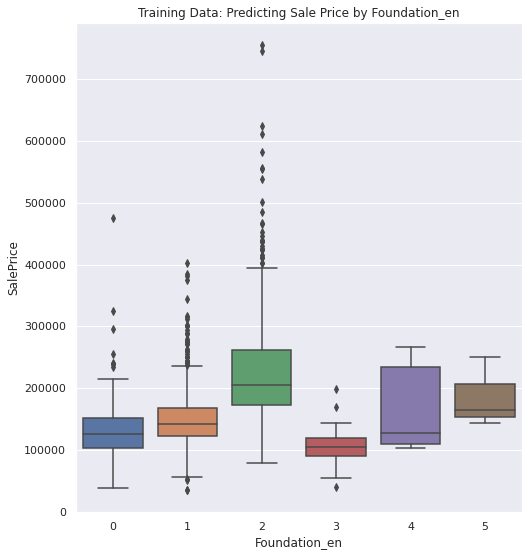

BsmtQual_en


<Figure size 432x288 with 0 Axes>

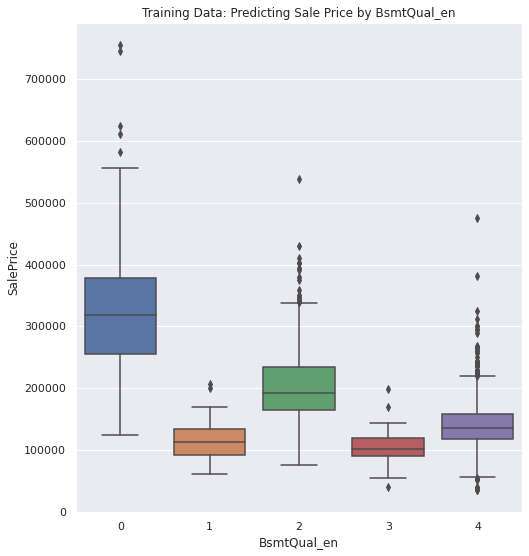

BsmtExposure_en


<Figure size 432x288 with 0 Axes>

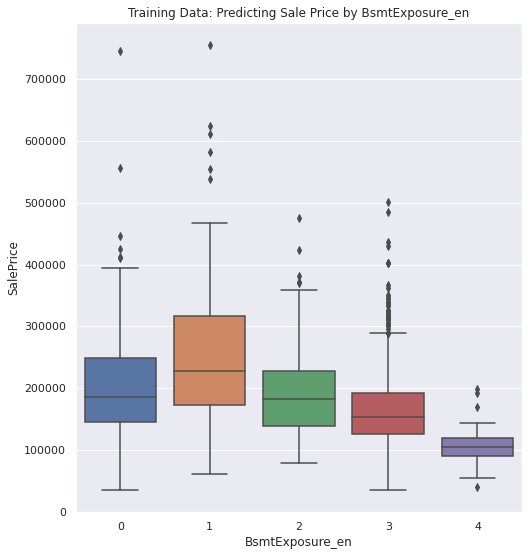

BsmtFinType1_en


<Figure size 432x288 with 0 Axes>

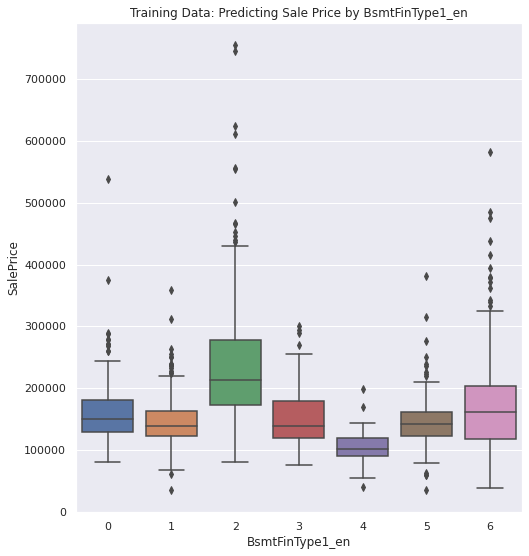

Heating_en


<Figure size 432x288 with 0 Axes>

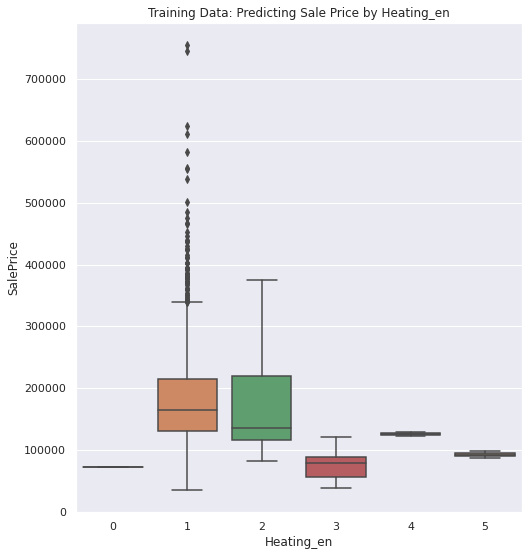

HeatingQC_en


<Figure size 432x288 with 0 Axes>

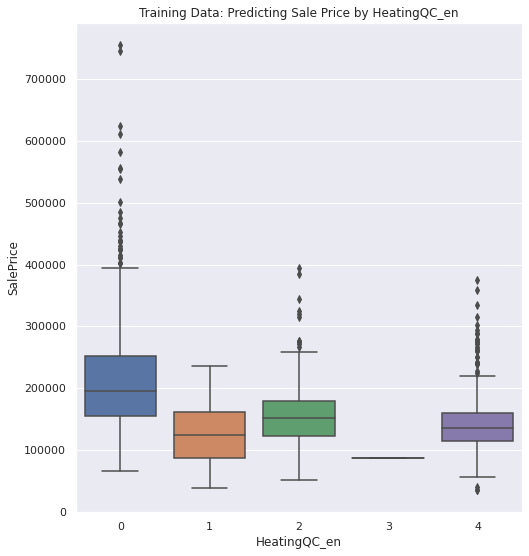

KitchenQual_en


<Figure size 432x288 with 0 Axes>

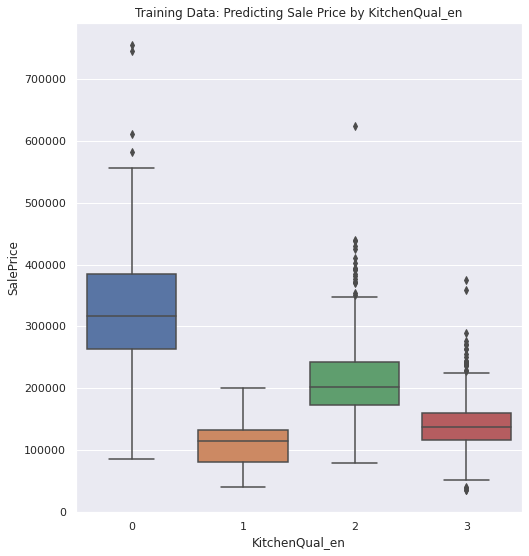

FireplaceQu_en


<Figure size 432x288 with 0 Axes>

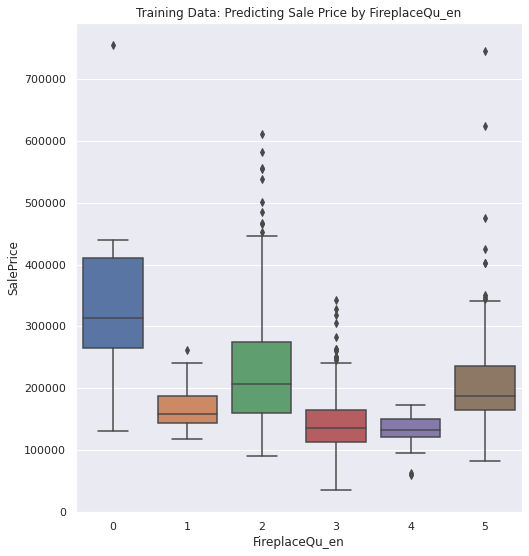

GarageType_en


<Figure size 432x288 with 0 Axes>

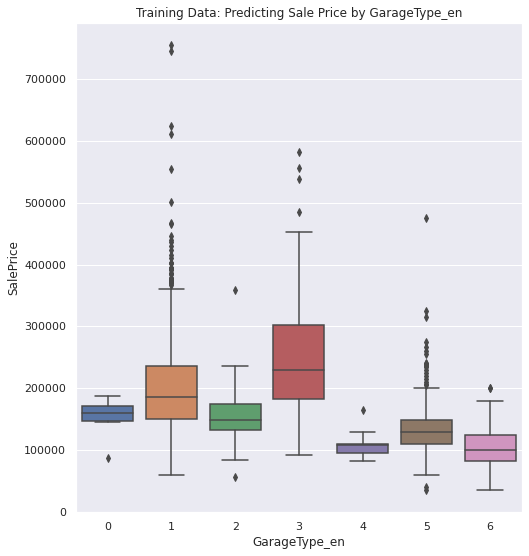

GarageFinish_en


<Figure size 432x288 with 0 Axes>

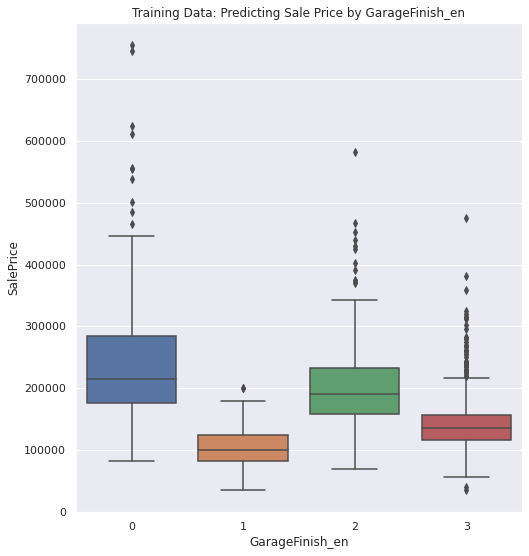

PoolQC_en


<Figure size 432x288 with 0 Axes>

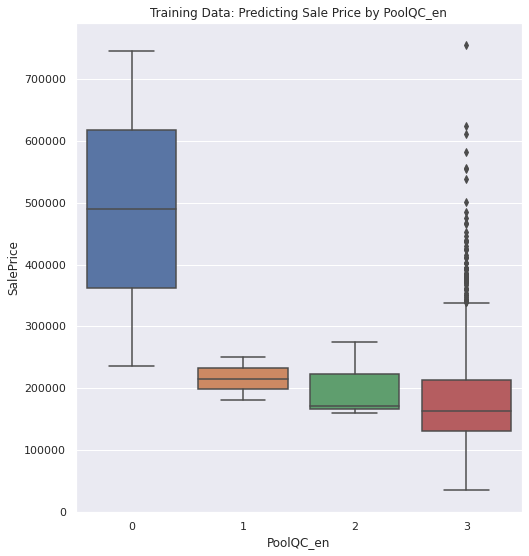

MiscFeature_en


<Figure size 432x288 with 0 Axes>

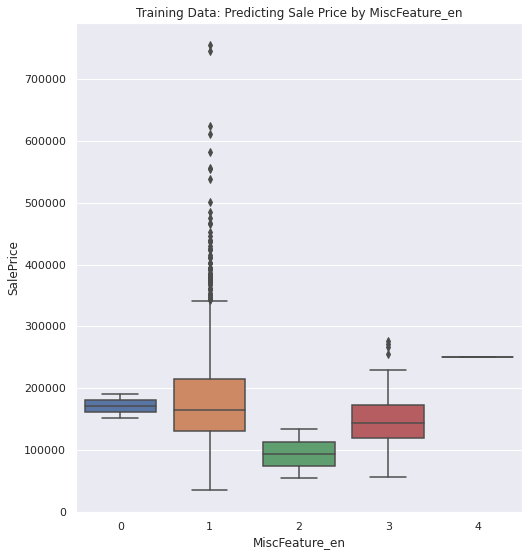

YearBuilt_bin


<Figure size 432x288 with 0 Axes>

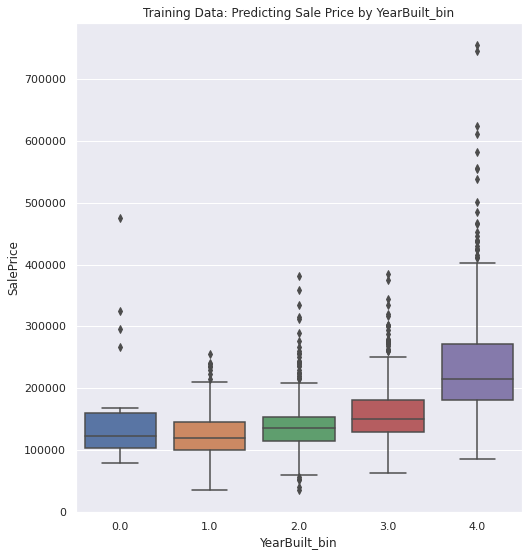

<Figure size 432x288 with 0 Axes>

In [30]:
sns.set_theme(color_codes=True)
# of_interest = ['ExterQual', 'GarageFinish', 'OverallQual',
#                'TotRmsAbvGrd', 'KitchenAbvGr']

for column in list(SalePrice_corr_train_quarters.index):
    # for variable in of_interest:
    #     if column == variable:
            if len(train[column].value_counts()) <= 50:
                print(f"{column}")
                plt.figure(figsize=(8,9), frameon=False)
                box = sns.boxplot(data=train, x=column, y='SalePrice')
                plt.title(f"Training Data: Predicting Sale Price by {column}")
                plt.show()
                box.figure.savefig(f"figures/boxplot_{column}.png")
                plt.tight_layout()
            else:
                print(f"{column}")
                plt.figure(figsize=(8,9), frameon=False)
                lmplot = sns.lmplot(data=train, x=column, y='SalePrice')
                plt.title(f"Training Data: Predicting Sale Price by {column}")
                plt.show()
                lmplot.figure.savefig(f"figures/lmplot_{column}.png")
                plt.tight_layout()


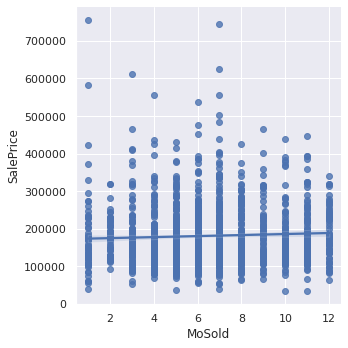

In [21]:
sns.lmplot(x='MoSold', y='SalePrice', data=train)

In [ ]:
for column in train.columns:
    for variable in of_interest+['SalePrice']:
        if column == variable:
            print(f"{column}")
            display(train[column].describe())

OverallQual


count    1460.000000
mean        6.099315
std         1.382997
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64

ExterQual


count     1460
unique       4
top         TA
freq       906
Name: ExterQual, dtype: object

KitchenAbvGr


count    1460.000000
mean        1.046575
std         0.220338
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: KitchenAbvGr, dtype: float64

TotRmsAbvGrd


count    1460.000000
mean        6.517808
std         1.625393
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        14.000000
Name: TotRmsAbvGrd, dtype: float64

GarageFinish


count     1379
unique       3
top        Unf
freq       605
Name: GarageFinish, dtype: object

SalePrice


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

OverallQual


<Figure size 1008x1008 with 0 Axes>

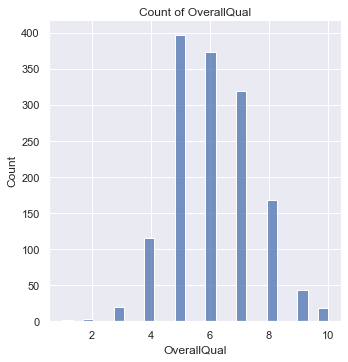

ExterQual


<Figure size 432x288 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

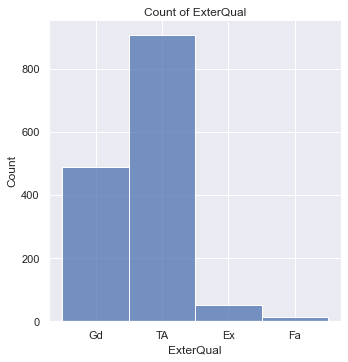

KitchenAbvGr


<Figure size 432x288 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

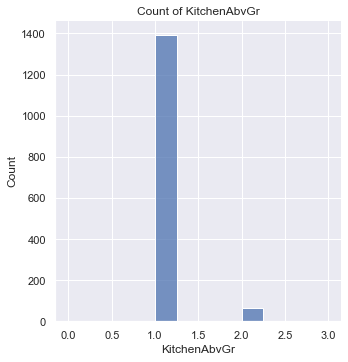

TotRmsAbvGrd


<Figure size 432x288 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

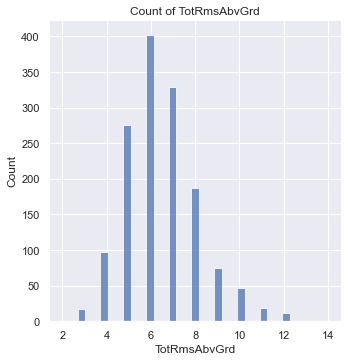

GarageFinish


<Figure size 432x288 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

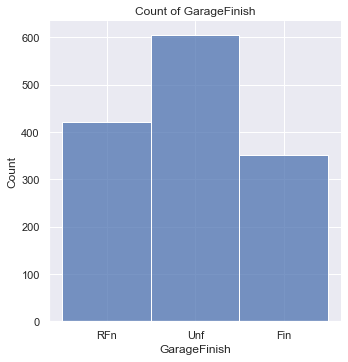

SalePrice


<Figure size 432x288 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

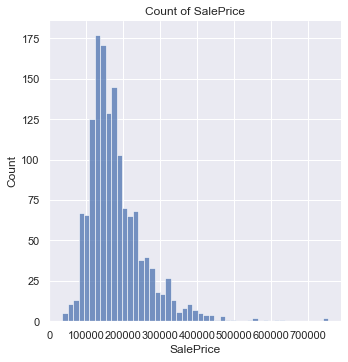

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.set_theme(color_codes=True)

for column in train.columns:
    for variable in of_interest+['SalePrice']:
        if column == variable:
            print(f"{column}")
            plt.figure(figsize=(14,14), frameon=False)
            s = sns.displot(train[column])
            plt.title(f"Count of {column}")
            plt.show()
            s.figure.savefig(f"figures/histogram_{column}.png")
            plt.tight_layout()

In [ ]:
non_numerical_col = list(set(train.columns) - set(train.corr().columns))

ExterQual


<Figure size 1080x1080 with 0 Axes>

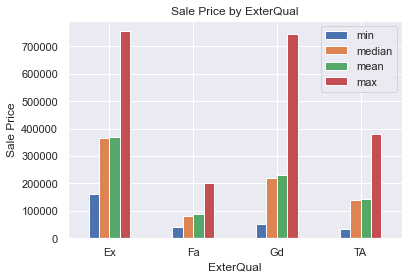

GarageFinish


<Figure size 1080x1080 with 0 Axes>

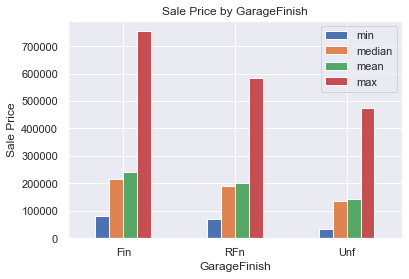

In [ ]:
for column in non_numerical_col:
    for variable in of_interest:
        if column == variable:
            print(f"{column}")
            plt.figure(figsize=(15,15), frameon=False)
            column_grouped = train['SalePrice'].groupby(train[column]).agg(['min', 'median', 'mean', 'max']).reset_index()
            grp_bar = column_grouped.plot.bar(x=column, rot=0.3)
            plt.ylabel('Sale Price')
            plt.title(f"Sale Price by {column}")
            plt.show()
            grp_bar.figure.savefig(f"figures/histogram_grouped_{column}_sale_price.png")

In [ ]:
character_train = pd.get_dummies(train.loc[:,non_numerical_col + ['SalePrice']])
scaler = StandardScaler()

character_train.corr()['SalePrice'].reset_index()[1:].sort_values(by='SalePrice',ascending=False).head(20)

,index,SalePrice
159,BsmtQual_Ex,0.553105
102,KitchenQual_Ex,0.504094
63,Foundation_PConc,0.497734
43,ExterQual_Gd,0.452466
41,ExterQual_Ex,0.451164
69,BsmtFinType1_GLQ,0.434597
240,HeatingQC_Ex,0.434543
223,GarageFinish_Fin,0.419678
179,Neighborhood_NridgHt,0.402149
20,SaleType_New,0.357509


In [ ]:
character_train.corr()['SalePrice'].reset_index()[1:].sort_values(by='SalePrice',ascending=True).head(20)

,index,SalePrice
44,ExterQual_TA,-0.589044
105,KitchenQual_TA,-0.519298
162,BsmtQual_TA,-0.452394
225,GarageFinish_Unf,-0.410608
83,MasVnrType_None,-0.374468
78,GarageType_Detchd,-0.354141
62,Foundation_CBlock,-0.343263
244,HeatingQC_TA,-0.312677
132,MSZoning_RM,-0.288065
26,LotShape_Reg,-0.267672


In [ ]:
train_grouped = train.groupby(of_interest).agg(['min', 'max', 'mean','median'])
train_saleprice_grp = train_grouped['SalePrice']
train_saleprice_grp

min     max  \
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr                   
Ex        Fin          6           6            1             185000  185000   
                       7           7            1             222000  222000   
                                   8            1             311872  311872   
                       8           5            1             392500  392500   
                                   7            1             318000  394617   
...                                                              ...     ...   
TA        Unf          7           10           1             244400  295000   
                                   11           1             320000  320000   
                       8           7            1             161000  230000   
                                   10           1             359100  359100   
                                   11           1             381000  381000   

                                                                       mean  \
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr                  
Ex        Fin          6           6            1             185000.000000   
                       7           7            1             222000.000000   
                                   8            1             311872.000000   
                       8           5            1             392500.000000   
                                   7            1             356308.500000   
...                                                                     ...   
TA        Unf          7           10           1             267226.666667   
                                   11           1             320000.000000   
                       8           7            1             195500.000000   
                                   10           1             359100.000000   
                                   11           1             381000.000000   

                                                                median  
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr            
Ex        Fin          6           6            1             185000.0  
                       7           7            1             222000.0  
                                   8            1             311872.0  
                       8           5            1             392500.0  
                                   7            1             356308.5  
...                                                                ...  
TA        Unf          7           10           1             262280.0  
                                   11           1             320000.0  
                       8           7            1             195500.0  
                                   10           1             359100.0  
                                   11           1             381000.0  

[218 rows x 4 columns]

In [ ]:
scaler = StandardScaler()
variables = ['min', 'max', 'mean', 'median']

train_standard = train_saleprice_grp
train_standard.loc[:, variables] = scaler.fit_transform(train_saleprice_grp[variables])
display(train_standard)

c:\users\oimar\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


min  \
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr             
Ex        Fin          6           6            1            -0.003977   
                       7           7            1             0.368132   
                                   8            1             1.271975   
                       8           5            1             2.082851   
                                   7            1             1.333604   
...                                                                ...   
TA        Unf          7           10           1             0.593409   
                                   11           1             1.353718   
                       8           7            1            -0.245345   
                                   10           1             1.746947   
                                   11           1             1.967195   

                                                                   max  \
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr             
Ex        Fin          6           6            1            -0.475248   
                       7           7            1            -0.157941   
                                   8            1             0.612788   
                       8           5            1             1.304242   
                                   7            1             1.322397   
...                                                                ...   
TA        Unf          7           10           1             0.468096   
                                   11           1             0.682493   
                       8           7            1            -0.089335   
                                   10           1             1.017809   
                                   11           1             1.205620   

                                                                  mean  \
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr             
Ex        Fin          6           6            1            -0.248115   
                       7           7            1             0.112687   
                                   8            1             0.989063   
                       8           5            1             1.775298   
                                   7            1             1.422381   
...                                                                ...   
TA        Unf          7           10           1             0.553709   
                                   11           1             1.068323   
                       8           7            1            -0.145725   
                                   10           1             1.449602   
                                   11           1             1.663157   

                                                                median  
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr            
Ex        Fin          6           6            1            -0.235795  
                       7           7            1             0.126388  
                                   8            1             1.006120  
                       8           5            1             1.795365  
                                   7            1             1.441097  
...                                                                ...  
TA        Unf          7           10           1             0.520678  
                                   11           1             1.085683  
                       8           7            1            -0.133013  
                                   10           1             1.468422  
                                   11           1             1.682795  

[218 rows x 4 columns]

In [ ]:
mm_scaler = MinMaxScaler()

train_minmax = train_saleprice_grp
mm_scaler.fit(train_saleprice_grp[variables])

train_minmax[variables] = mm_scaler.fit_transform(train_saleprice_grp[variables])
display(train_minmax)

c:\users\oimar\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


min  \
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr             
Ex        Fin          6           6            1             0.253844   
                       7           7            1             0.316589   
                                   8            1             0.468995   
                       8           5            1             0.605724   
                                   7            1             0.479387   
...                                                                ...   
TA        Unf          7           10           1             0.354575   
                                   11           1             0.482778   
                       8           7            1             0.213145   
                                   10           1             0.549084   
                                   11           1             0.586223   

                                                                   max  \
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr             
Ex        Fin          6           6            1             0.207991   
                       7           7            1             0.259402   
                                   8            1             0.384278   
                       8           5            1             0.496310   
                                   7            1             0.499252   
...                                                                ...   
TA        Unf          7           10           1             0.360835   
                                   11           1             0.395572   
                       8           7            1             0.270518   
                                   10           1             0.449901   
                                   11           1             0.480331   

                                                                  mean  \
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr             
Ex        Fin          6           6            1             0.230401   
                       7           7            1             0.287351   
                                   8            1             0.425682   
                       8           5            1             0.549785   
                                   7            1             0.494079   
...                                                                ...   
TA        Unf          7           10           1             0.356964   
                                   11           1             0.438193   
                       8           7            1             0.246563   
                                   10           1             0.498375   
                                   11           1             0.532084   

                                                                median  
ExterQual GarageFinish OverallQual TotRmsAbvGrd KitchenAbvGr            
Ex        Fin          6           6            1             0.230401  
                       7           7            1             0.287351  
                                   8            1             0.425682  
                       8           5            1             0.549785  
                                   7            1             0.494079  
...                                                                ...  
TA        Unf          7           10           1             0.349350  
                                   11           1             0.438193  
                       8           7            1             0.246563  
                                   10           1             0.498375  
                                   11           1             0.532084  

[218 rows x 4 columns]